In [3]:
id_ = 'core'
backup_dir = '/root/datos/maestria/netopaas/luca/data/atlas/'


# UTX (KDM6A) and KMT2D in Proto and Anti Oncogenicity

## Import

In [89]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as scp

import scanpy as sc

In [4]:
adata = sc.read_h5ad(f'{backup_dir}/{id_}.h5ad')

In [73]:
adata.obs.groupby('tumor_stage').size()

/tmp/ipykernel_19935/226547110.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('tumor_stage').size()


tumor_stage
advanced      245051
early         379059
nan               43
non-cancer    268143
dtype: int64

## Plot genes

In [41]:
ens_kd = adata.var.ensemble[adata.var.feature_name == 'KDM6A'][0]
ens_km = adata.var.ensemble[adata.var.feature_name == 'KMT2D'][0]

/tmp/ipykernel_19935/2833638835.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ens_kd = adata.var.ensemble[adata.var.feature_name == 'KDM6A'][0]
/tmp/ipykernel_19935/2833638835.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ens_km = adata.var.ensemble[adata.var.feature_name == 'KMT2D'][0]


/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


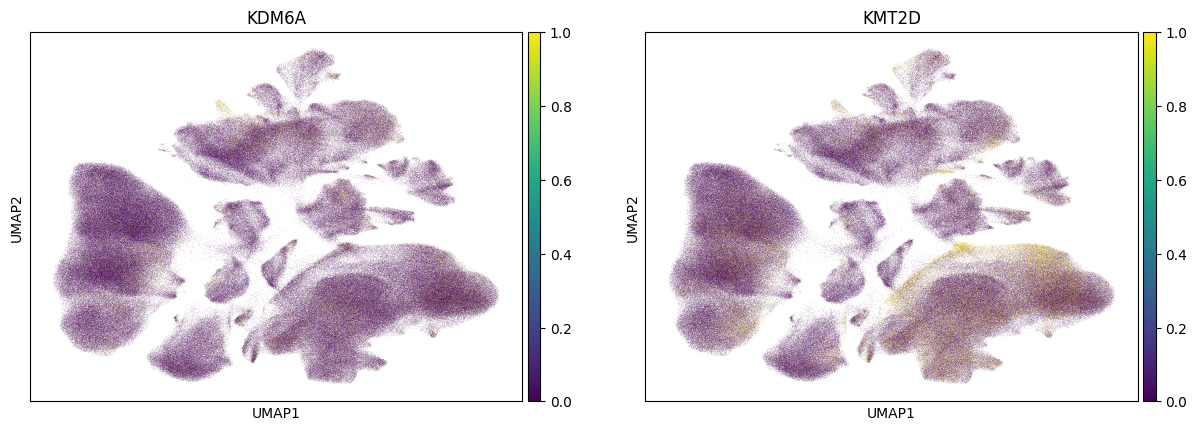

In [70]:
sc.pl.umap(adata, color=[ens_km, ens_kd], vmax = 1, title=['KDM6A', 'KMT2D'])

In [196]:
adata_kd = adata[:,adata.var.index == ens_kd]
adata_km = adata[:,adata.var.index == ens_km]

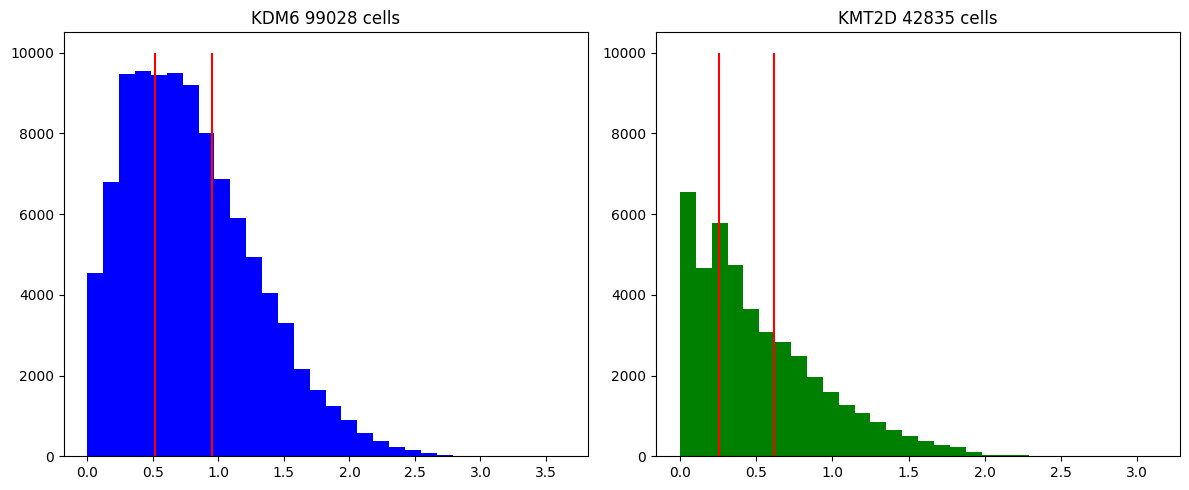

In [102]:
points_kd = adata_kd.X.data
points_km = adata_km.X.data

quant_kd = np.quantile(points_kd, [0.33, 0.66])
quant_km = np.quantile(points_km, [0.33, 0.66])

# Set up the matplotlib figure
plt.figure(figsize=(12, 5))

# First histogram
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.hist(points_kd, bins=30, color='blue')
plt.vlines(quant_kd, ymin=0, ymax=10000, colors='red')
plt.title(f'KDM6 {len(points_kd)} cells')

# Second histogram
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.hist(adata_km.X.data, bins=30, color='green')
plt.vlines(quant_km, ymin=0, ymax=10000, colors='red')
plt.title(f'KMT2D {len(points_km)} cells')

# Display the plots
plt.tight_layout()
plt.show()

Check if we have sequenced the genes

In [110]:
adata.var.feature_name[adata.var.feature_name.str.startswith("MCM")]

ensemble
ENSG00000065328         MCM10
ENSG00000073111          MCM2
ENSG00000112118          MCM3
ENSG00000160294        MCM3AP
ENSG00000215424    MCM3AP-AS1
ENSG00000104738          MCM4
ENSG00000100297          MCM5
ENSG00000076003          MCM6
ENSG00000166508          MCM7
ENSG00000125885          MCM8
ENSG00000111877          MCM9
ENSG00000197771         MCMBP
ENSG00000178460        MCMDC2
Name: feature_name, dtype: category
Categories (17811, object): ['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', ..., 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1']

We got this as genes that are involved in the DNA duplication cycle
Get the quantiles and the views neccessary for plotting specfici conditions

In [180]:
duplication_genes = ['MCM3', 'NRP1', 'RPA1', 'RFC1','LIG1' ]
levels_quant = ['blue', 'green', 'red']
adata_duplication = adata[:, adata.var.feature_name.isin(duplication_genes), :]
tumor_diseases = ['lung adenocarcinoma', 'squamous cell lung carcinoma', 'non-small cell lung carcinoma']

# Add the final value to divide cells into 3 quantiles
quant_kd = np.quantile(points_kd, [0.33, 0.66])
quant_km = np.quantile(points_km, [0.33, 0.66])
quant_kd = list(quant_kd) + [3]
quant_km = list(quant_km) + [3]

In [203]:
adata_duplication_tumor = adata_duplication[adata_duplication.obs.disease.isin(tumor_diseases), :]
adata_duplication_normal = adata_duplication[adata_duplication.obs.disease.isin(['normal']), :]

adata_kd_tumor = adata_kd[adata_duplication.obs.disease.isin(tumor_diseases), :]
adata_kd_normal = adata_kd[adata_duplication.obs.disease.isin(['normal']), :]

adata_km_tumor = adata_km[adata_duplication.obs.disease.isin(tumor_diseases), :]
adata_km_normal = adata_km[adata_duplication.obs.disease.isin(['normal']), :]

### KMT2D & KDM6A

#### Normal & Tumor

/usr/local/lib/python3.11/site-packages/scipy/sparse/_compressed.py:290: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


MCM3
NRP1
RPA1
RFC1
LIG1
MCM3
NRP1
RPA1
RFC1
LIG1
MCM3
NRP1
RPA1
RFC1
LIG1


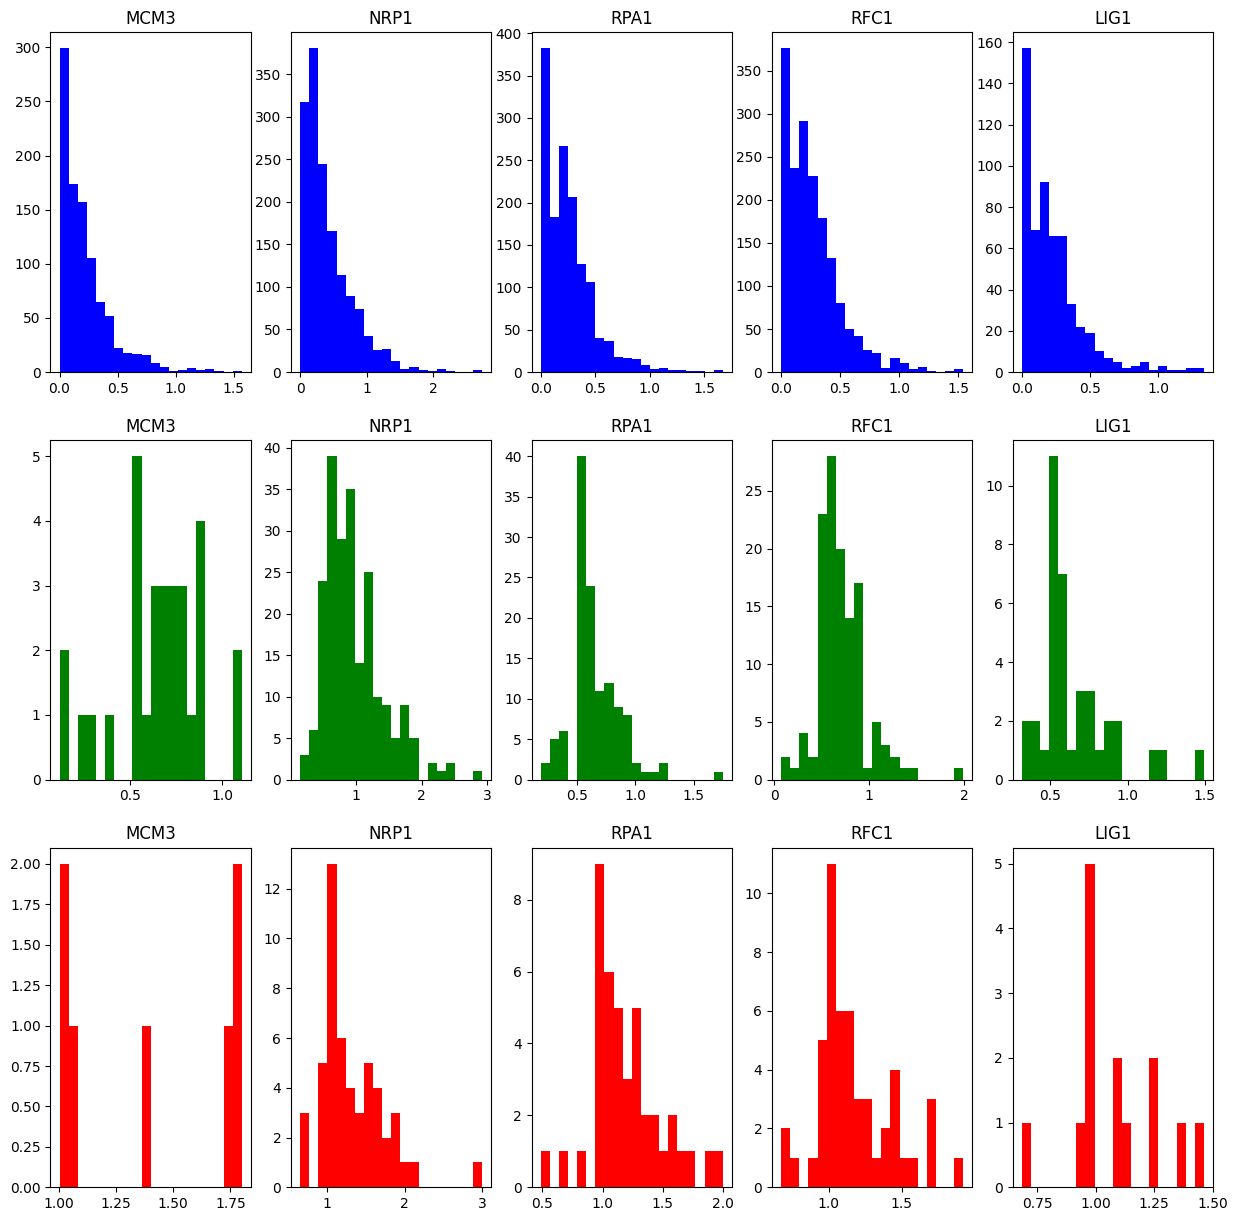

In [170]:
plt.figure(figsize=(15, 15))

for i, quant in enumerate(quant_kd):
    quant_ = 0 if i == 0 else quant_kd[i-1]
    # We use multiply because sparse matrices
    condition_kd = (adata_kd.X < quant).multiply(adata_kd.X > quant_)
    condition_km = (adata_km.X < quant).multiply(adata_km.X > quant_)
    adata_quant = adata_duplication[condition_kd.multiply(condition_km), : ]

    for j, gene in enumerate(duplication_genes):
        print(gene)
        adata_gene = adata_quant[:, adata_quant.var.feature_name == gene]
        plt.subplot(3, 5, i*len(duplication_genes) + j+1) # 3 rows, 5 columns ith plot
        plt.hist(adata_gene.X.data, bins=20, color=levels_quant[i])
        plt.title(gene)

plt.show()

#### Tumor

/usr/local/lib/python3.11/site-packages/scipy/sparse/_compressed.py:290: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


MCM3
NRP1
RPA1
RFC1
LIG1
MCM3
NRP1
RPA1
RFC1
LIG1
MCM3
NRP1
RPA1
RFC1
LIG1


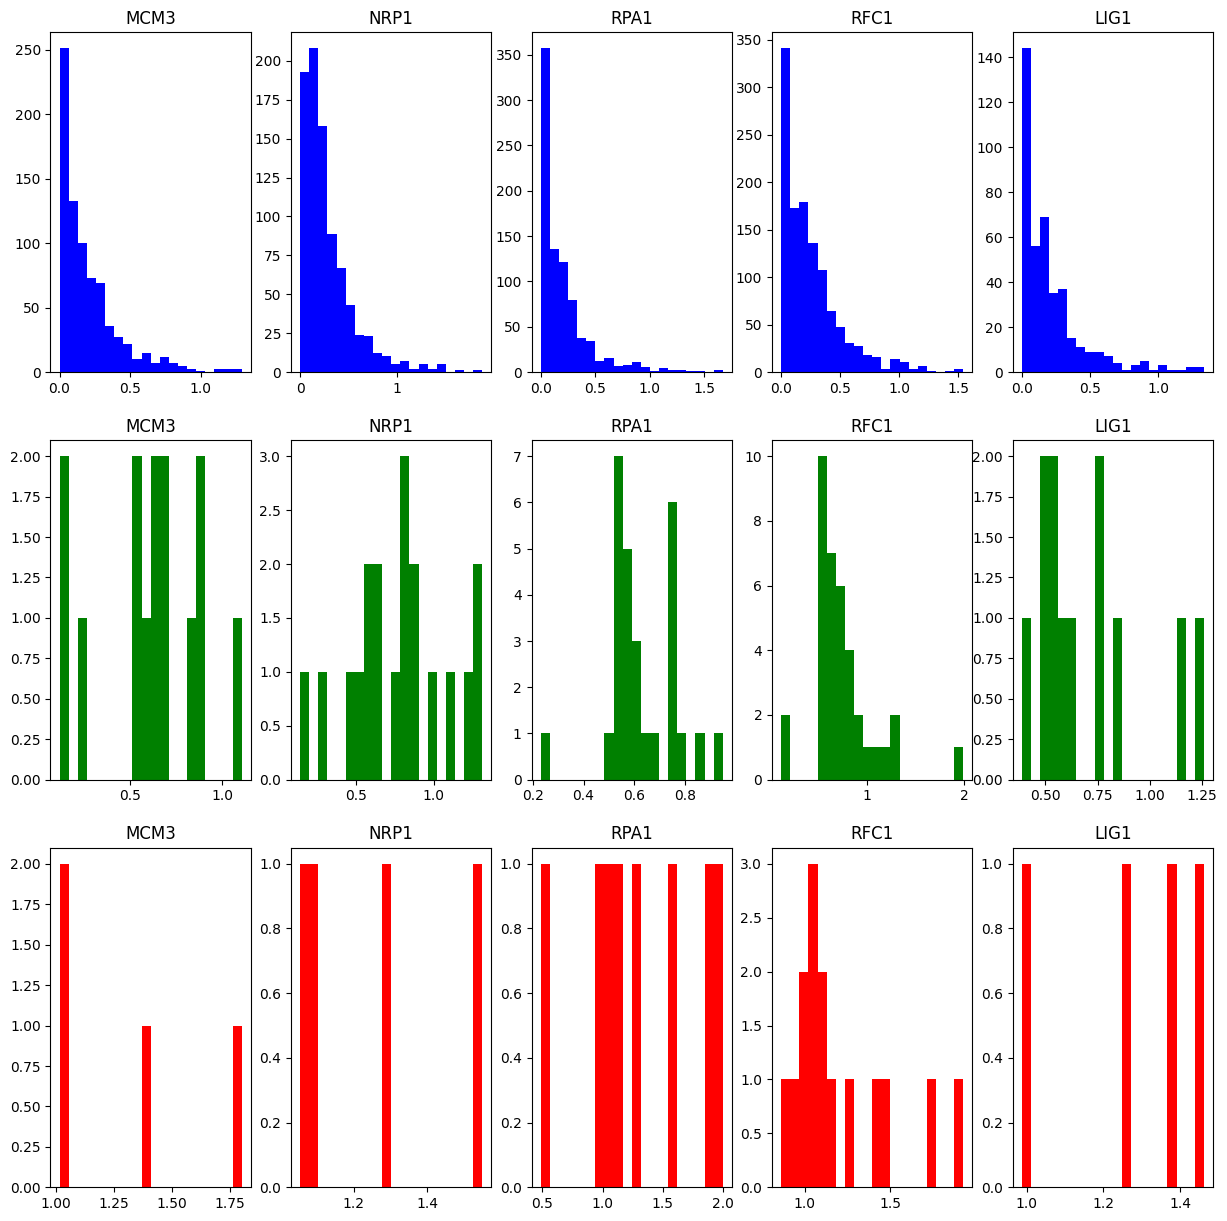

In [215]:
plt.figure(figsize=(15, 15))

adata_duplication_ = adata_duplication
adata_duplication = adata_duplication_tumor

adata_km_ = adata_km
adata_km = adata_km_tumor

adata_kd_ = adata_kd
adata_kd = adata_kd_tumor

for i, quant in enumerate(quant_kd):
    quant_ = 0 if i == 0 else quant_kd[i-1]
    # We use multiply because sparse matrices
    condition_kd = (adata_kd.X < quant).multiply(adata_kd.X > quant_)
    condition_km = (adata_km.X < quant).multiply(adata_km.X > quant_)
    adata_quant = adata_duplication[condition_kd.multiply(condition_km), : ]

    for j, gene in enumerate(duplication_genes):
        print(gene)
        adata_gene = adata_quant[:, adata_quant.var.feature_name == gene]
        plt.subplot(3, 5, i*len(duplication_genes) + j+1) # 3 rows, 5 columns ith plot
        plt.hist(adata_gene.X.data, bins=20, color=levels_quant[i])
        plt.title(gene)

adata_duplication = adata_duplication_
adata_km = adata_km_
adata_kd = adata_kd_
plt.show()

#### Normal

/usr/local/lib/python3.11/site-packages/scipy/sparse/_compressed.py:290: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


MCM3
NRP1
RPA1
RFC1
LIG1
MCM3
NRP1
RPA1
RFC1
LIG1
MCM3
NRP1
RPA1
RFC1
LIG1


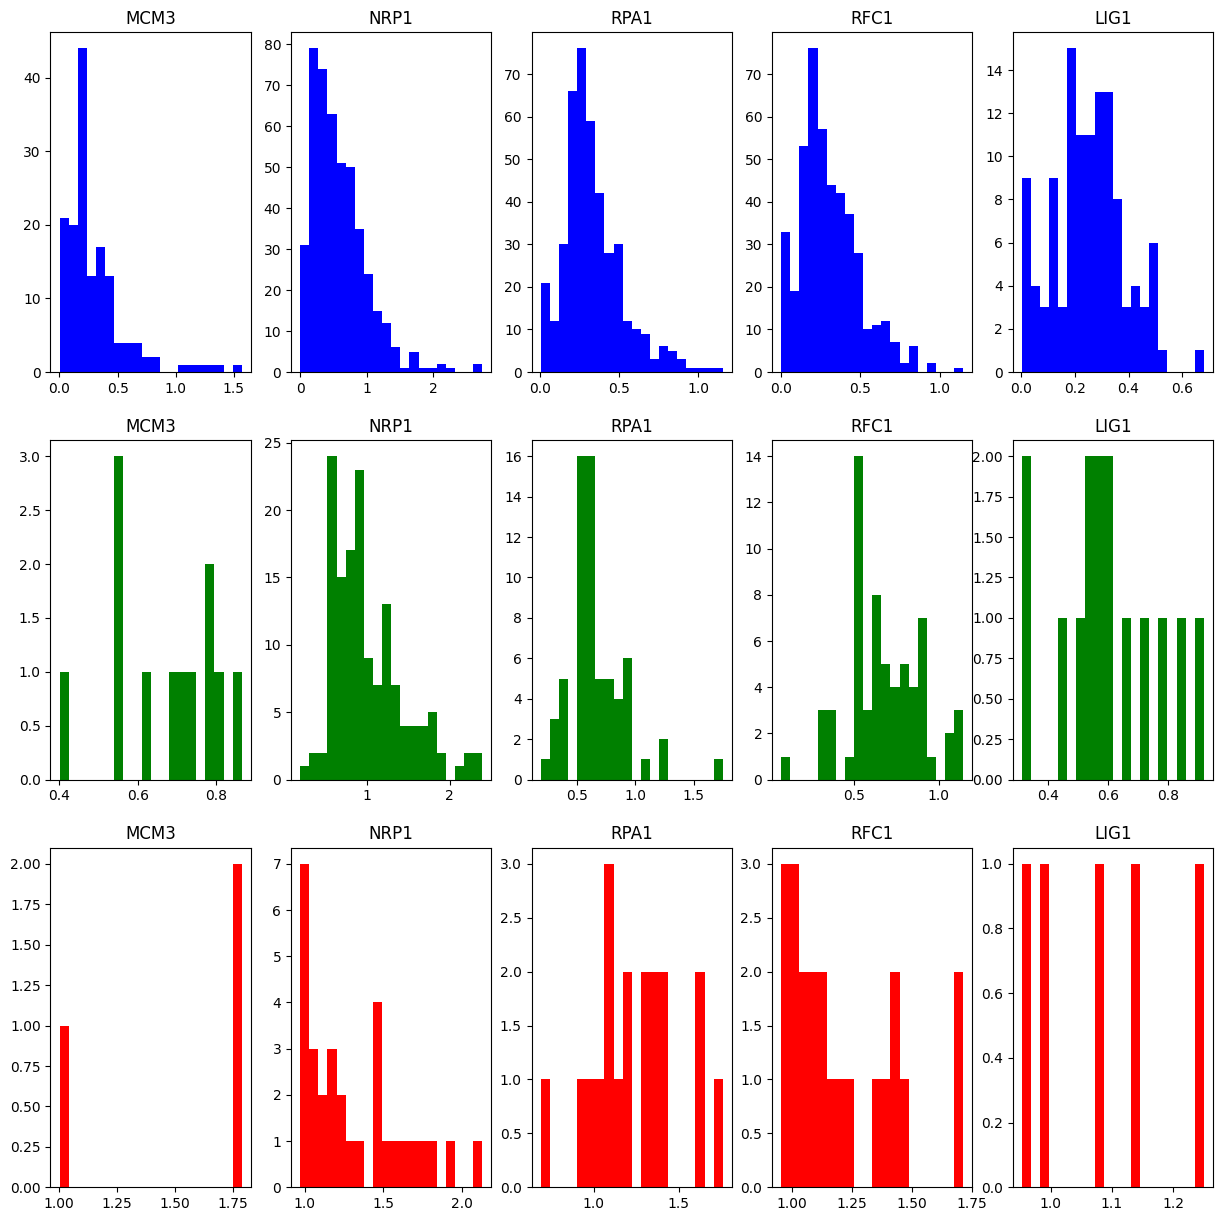

In [217]:
plt.figure(figsize=(15, 15))

adata_duplication_ = adata_duplication
adata_duplication = adata_duplication_normal

adata_km_ = adata_km
adata_km = adata_km_normal

adata_kd_ = adata_kd
adata_kd = adata_kd_normal

for i, quant in enumerate(quant_kd):
    quant_ = 0 if i == 0 else quant_kd[i-1]
    # We use multiply because sparse matrices
    condition_kd = (adata_kd.X < quant).multiply(adata_kd.X > quant_)
    condition_km = (adata_km.X < quant).multiply(adata_km.X > quant_)
    adata_quant = adata_duplication[condition_kd.multiply(condition_km), : ]

    for j, gene in enumerate(duplication_genes):
        print(gene)
        adata_gene = adata_quant[:, adata_quant.var.feature_name == gene]
        plt.subplot(3, 5, i*len(duplication_genes) + j+1) # 3 rows, 5 columns ith plot
        plt.hist(adata_gene.X.data, bins=20, color=levels_quant[i])
        plt.title(gene)

adata_duplication = adata_duplication_
adata_km = adata_km_
adata_kd = adata_kd_
plt.show()

### KMT2D

MCM3
NRP1
RPA1
RFC1
LIG1
MCM3
NRP1
RPA1
RFC1
LIG1
MCM3
NRP1
RPA1
RFC1
LIG1


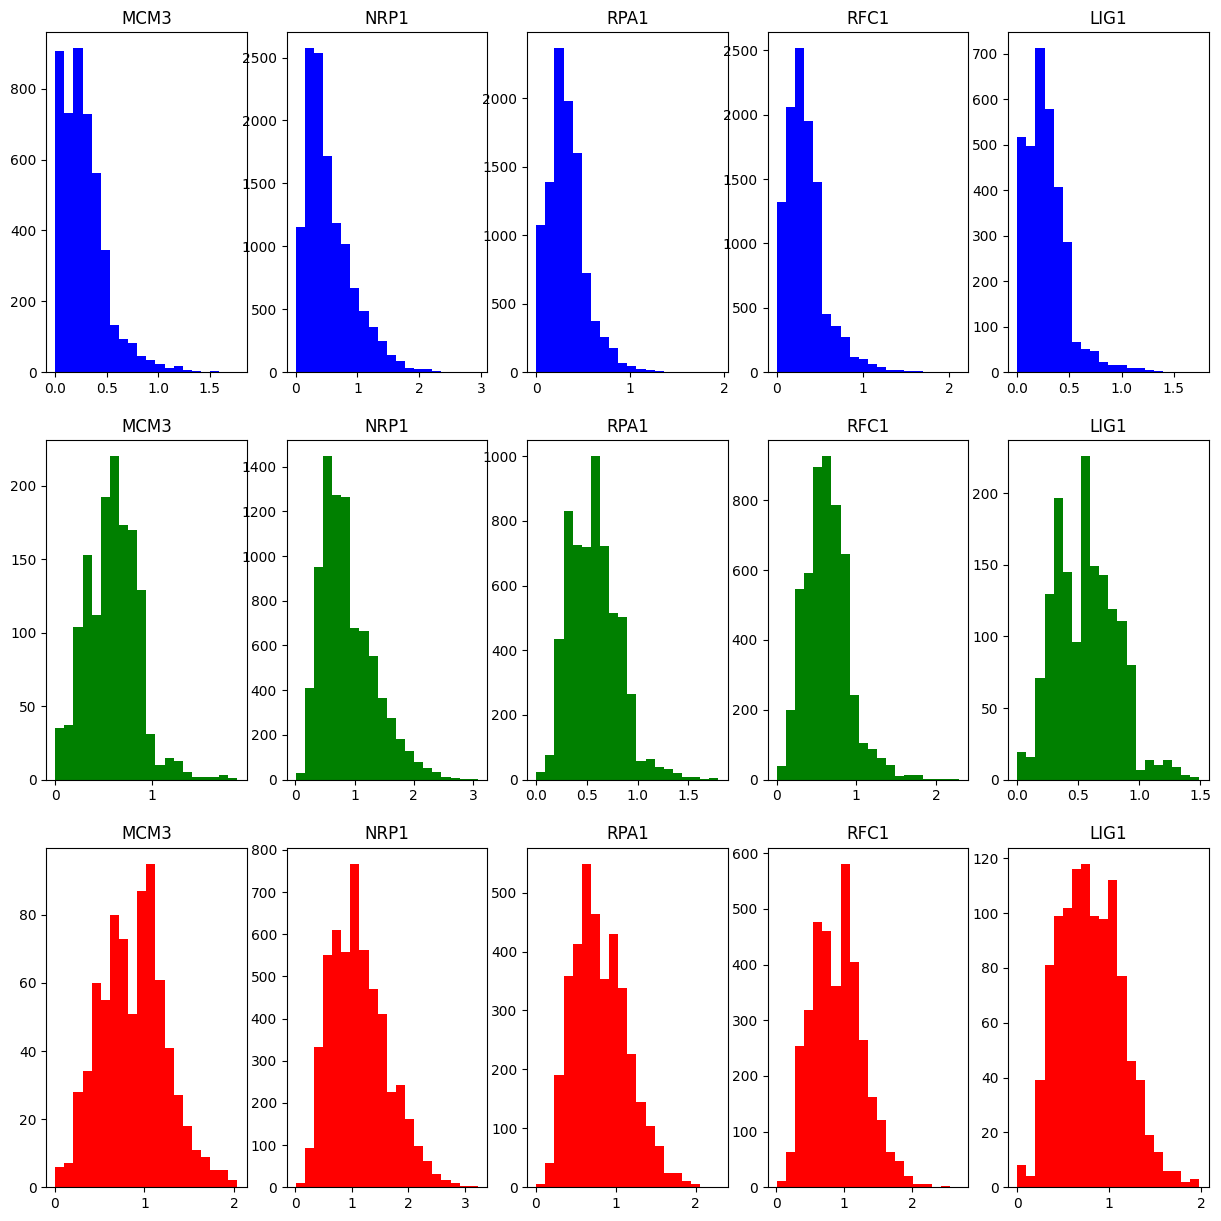

In [168]:
plt.figure(figsize=(15, 15))

for i, quant in enumerate(quant_kd):
    quant_ = 0 if i == 0 else quant_kd[i-1]
    # We use multiply because sparse matrices
    adata_quant = adata_duplication[(adata_kd.X < quant).multiply(adata_kd.X > quant_), : ]

    for j, gene in enumerate(duplication_genes):
        print(gene)
        adata_gene = adata_quant[:, adata_quant.var.feature_name == gene]
        plt.subplot(3, 5, i*len(duplication_genes) + j+1) # 3 rows, 5 columns ith plot
        plt.hist(adata_gene.X.data, bins=20, color=levels_quant[i])
        plt.title(gene)

plt.show()

### KMD6A

MCM3
NRP1
RPA1
RFC1
LIG1
MCM3
NRP1
RPA1
RFC1
LIG1
MCM3
NRP1
RPA1
RFC1
LIG1


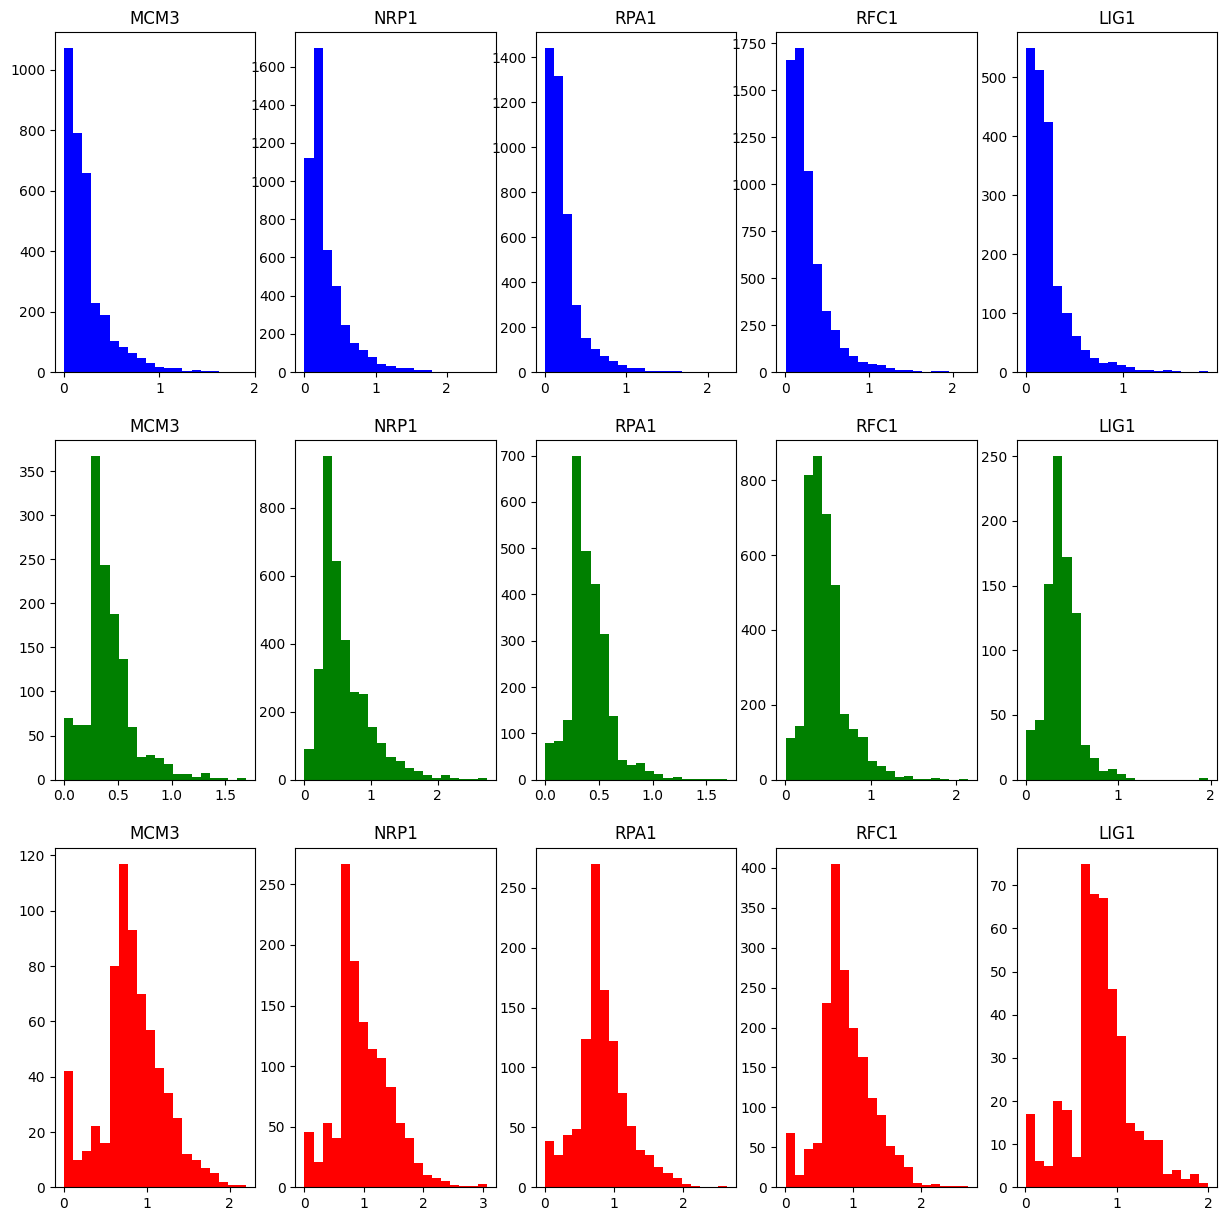

In [169]:
plt.figure(figsize=(15, 15))

for i, quant in enumerate(quant_km):
    quant_ = 0 if i == 0 else quant_km[i-1]
    # We use multiply because sparse matrices
    adata_quant = adata_duplication[(adata_km.X < quant).multiply(adata_km.X > quant_), : ]

    for j, gene in enumerate(duplication_genes):
        print(gene)
        adata_gene = adata_quant[:, adata_quant.var.feature_name == gene]
        plt.subplot(3, 5, i*len(duplication_genes) + j+1) # 3 rows, 5 columns ith plot
        plt.hist(adata_gene.X.data, bins=20, color=levels_quant[i])
        plt.title(gene)

plt.show()